# BASELINE MODEL FOR RWIS RSC CLASSIFICATION + WEATHER

## Import libraries

In [1]:
# Libraries for file and data handling
%matplotlib inline
import os, sys
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import misc
import imageio
from keras.models import model_from_json
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import pickle
from random import shuffle, seed
seed(444)

Using TensorFlow backend.


## Data preparation

In [2]:
# Load the lists detailing the train and test files
with open('../input/rwis-data-split/split.pickle', 'rb') as handle:
    split_dic = pickle.load(handle)

In [3]:
# Obtain the lists
train = split_dic['train']
print('Images in train set:' + str(len(train)))
test = split_dic['test']
print('Images in test set:' + str(len(test)))

Images in train set:12600
Images in test set:1400


In [4]:
# Image dimensions
image_height = 299
image_width = 299
channels = 3
display_images = True

In [5]:
label_names = ['Bare pavement', 'Partial snow coverage', 'Full snow coverage']

In [6]:
# Function that prints the total number of images per category in the given set
def print_items(list_of_files):
    cat1 = 0
    cat2 = 0
    cat3 = 0
    for ifile in list_of_files:
        if 'C1' in ifile:
            cat1 += 1
        elif 'C2' in ifile:
            cat2 += 1
        elif 'C3' in ifile:
            cat3 += 1
    total = cat1+cat2+cat3
    print ('Total images: ' + str(total))
    print (label_names[0] + ' ' + str(cat1) + ' Approx. ' + str(int(cat1/total*100)) + '%')
    print (label_names[1] + ' ' + str(cat2) + ' Approx. ' + str(int(cat2/total*100)) + '%')
    print (label_names[2] + ' ' + str(cat3) + ' Approx. ' + str(int(cat3/total*100)) + '%')

In [7]:
print('- Summary of images in the train set -')
print_items(train)

- Summary of images in the train set -
Total images: 12600
Bare pavement 5691 Approx. 45%
Partial snow coverage 5114 Approx. 40%
Full snow coverage 1795 Approx. 14%


In [8]:
print('- Summary of images in the test set -')
print_items(test)

- Summary of images in the test set -
Total images: 1400
Bare pavement 648 Approx. 46%
Partial snow coverage 558 Approx. 39%
Full snow coverage 194 Approx. 13%


In [9]:
# Function to convert list of image filenames into numpy X and Y arrays
def getArrays(folder, list_of_files):
    
    # Number of images in the list
    numim = len(list_of_files)
    # Prepare array for the images
    images_array = np.ndarray(shape=(numim, image_height, image_width, channels), dtype=np.float16)
    # Prepare array for the labels
    labels_array = np.ndarray(shape = numim,dtype=np.uint8)
    # Set some counters
    idx_files = 0
    completion = 20
    
    # Loop over the filenames
    for ifile in list_of_files:
        fullpath = folder + ifile
        # From filename to numpy array
        img_arr = imageio.imread(fullpath)
        images_array[idx_files] = img_arr / 255.0
        # Obtain label from filename
        if '/C1/' in ifile:
            label = 0
        elif '/C2/' in ifile:
            label = 1
        elif '/C3/' in ifile:
            label = 2
        labels_array[idx_files] = label
        idx_files += 1
        
        # Print % of completion
        if (idx_files+1) % (numim//5) == 0:
            print('Completed ' + str(completion) + '%')
            completion += 20

    return images_array, labels_array

In [10]:
folder = "../input/rwis299/rwis299/rwis299"

In [11]:
# Import the corresponding images into numpy arrays 
X_train, y_train = getArrays(folder, train)
print('X_train shape is ' + str(X_train.shape))
print('y_train shape is ' + str(y_train.shape))

Completed 20%
Completed 40%
Completed 60%
Completed 80%
Completed 100%
X_train shape is (12600, 299, 299, 3)
y_train shape is (12600,)


In [12]:
# Import the corresponding images into numpy arrays 
X_test, y_test = getArrays(folder, test)
print('X_test shape is ' + str(X_test.shape))
print('y_test shape is ' + str(y_test.shape))

Completed 20%
Completed 40%
Completed 60%
Completed 80%
Completed 100%
X_test shape is (1400, 299, 299, 3)
y_test shape is (1400,)


/ER-14/C2/ER-Hwy401_Curry_Hill-p3-1515260700.jpg


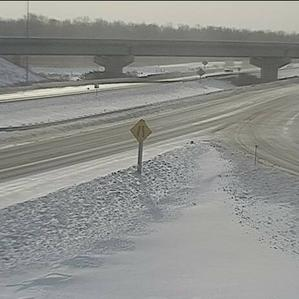

/ER-32/C3/ER-Hwy416_Rideau_River-p3-1515841200.jpg


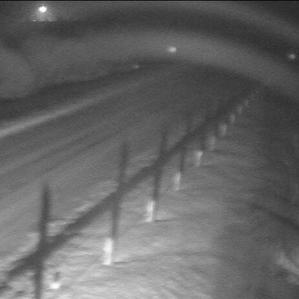

In [13]:
# Display some images from the train set
if display_images:    
    for i in range(0, 2):
        print(train[i])
        display(_Imgdis(filename=folder+train[i], width = image_width, height = image_height))

/CR-19/C2/CR-Hwy401_near_Newtonville_Rd-p1-1513948500.jpg


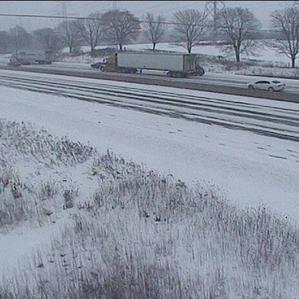

/NER-14/C1/NER-Hwy11_Marten_River-p1-1515527100.jpg


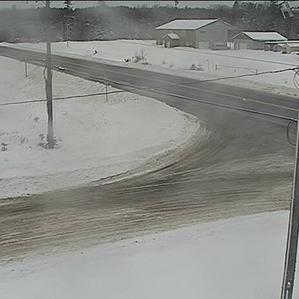

In [14]:
# Display some images from the test set
if display_images:
    for i in range(0, 2):
        print(test[i])
        display(_Imgdis(filename=folder+test[i], width = image_width, height = image_height))

## Model preparation

In [15]:
#Import Keras and TensorFlow libraries
from keras.preprocessing import image
from keras.models import Model
from keras import backend as K
from time import time
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras import optimizers
from keras.utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard

In [16]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [17]:
# Convert class vectors to binary class matrices.
num_classes = 3
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [18]:
print(y_train.shape)
print(y_test.shape)

(12600, 3)
(1400, 3)


## Importing the model

In [19]:
# load json and create model
json_file = open('../input/dcnn-model/model_icf_17_fce_5.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
view_model = True
if view_model:
    print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 297, 297, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 27)      3915      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 27)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 46)        11224     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 46)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 79)        32785     
__________

In [21]:
# load weights into new model
model.load_weights("../input/dcnn-weights/model_icf_17_fce_5_weights.h5")
print("Loaded weights into the model")

Loaded weights into the model


## Using the DCNN to output embeddings for all images

In [22]:
opt = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [23]:
# Predict for images in the train set
X_train_DCNN = model.predict(X_train)

In [24]:
# Predict for images in the test set
X_test_DCNN = model.predict(X_test)

In [25]:
print("X_train_DCNN")
print(X_train_DCNN.shape)
print("X_test_DCNN")
print(X_test_DCNN.shape)

X_train_DCNN
(12600, 3)
X_test_DCNN
(1400, 3)


## Add weather variables

In [26]:
# Load the dictionary with only four main variables. Image file paths as keys
# and per-image dictionaries include four main weather variables
with open('../input/weather-rwis/weather_rwis_4v/weather_rwis_4v.pickle', 'rb') as handle:
    weather_rwis_dic_4v = pickle.load(handle)

In [27]:
# Function to takes list of image filenames and weather data and turns
# the weather variables into a numpy array
def getWeatherArray(list_of_files, weather_dic):
    
    # Number of images in the list
    numim = len(list_of_files)
    # Prepare array for the weather variables (4)
    weather_array = np.ndarray(shape=(numim, 4), dtype=np.float16)
    # Set some counters
    idx_files = 0
    completion = 20
    # List with weather variables for a particular image
    weather_i = []
    
    # Loop over the filenames
    for ifile in list_of_files:
        weather_i.clear()
        weather_i.append(weather_dic[ifile]['Air Temp (°C)'])
        weather_i.append(weather_dic[ifile]['Relative Humidity\xa0(%)'])
        weather_i.append(weather_dic[ifile]['Pressure (kPa)'])
        weather_i.append(weather_dic[ifile]['Wind Speed (km/h)'])
        # From weather list to numpy array
        weather_array[idx_files] = np.array(weather_i)
        
        idx_files += 1
        
        # Print % of completion
        if (idx_files+1) % (numim//5) == 0:
            print('Completed ' + str(completion) + '%')
            completion += 20

    return weather_array

In [28]:
# Get weather array for images in the train set
weather_array_train = getWeatherArray(train, weather_rwis_dic_4v)

Completed 20%
Completed 40%
Completed 60%
Completed 80%
Completed 100%


In [29]:
# Get weather array for images in the test set
weather_array_test = getWeatherArray(test, weather_rwis_dic_4v)

Completed 20%
Completed 40%
Completed 60%
Completed 80%
Completed 100%


In [30]:
print("weather_array_train")
print(weather_array_train.shape)
print("weather_array_test")
print(weather_array_test.shape)

weather_array_train
(12600, 4)
weather_array_test
(1400, 4)


## Concatenate with output from the DCNN

In [31]:
# See embeddings from the DCNN
print("X_train_DCNN")
print(X_train_DCNN.shape)
print("X_test_DCNN")
print(X_test_DCNN.shape)

X_train_DCNN
(12600, 3)
X_test_DCNN
(1400, 3)


In [32]:
# Concatenate for samples in the train set
print ('Joining the two arrays along axis 1:' )
X_train = np.concatenate((X_train_DCNN,weather_array_train),axis = 1)
print(X_train.shape)

Joining the two arrays along axis 1:
(12600, 7)


In [33]:
# Concatenate for samples in the test set
print ('Joining the two arrays along axis 1:' )
X_test = np.concatenate((X_test_DCNN,weather_array_test),axis = 1)
print(X_test.shape)

Joining the two arrays along axis 1:
(1400, 7)


## Summary statistics, data cleaning and normalization

In [34]:
# Concatenate output features from the Deep Convolutional Neural Network
# with the weather variables
columns = ["dcnn_f1", "dcnn_f2", "dcnn_f3", "Air Temp (°C)", "Relative Humidity(%)", 
           "Pressure (kPa)", "Wind Speed (km/h)"]

In [35]:
# Converto to pandas dataframes
X_train_df = pd.DataFrame(data=X_train, columns=columns)
X_test_df = pd.DataFrame(data=X_test, columns=columns)

In [36]:
# Preview some entries in the train set
X_train_df.head()

,dcnn_f1,dcnn_f2,dcnn_f3,Air Temp (°C),Relative Humidity(%),Pressure (kPa),Wind Speed (km/h)
0,0.057684,0.883721,0.058594,-22.703125,78.0,102.0625,31.0
1,0.011295,0.138644,0.850061,-15.296875,81.0,89.1250,16.0
2,0.060144,0.915987,0.023869,-19.406250,70.0,97.1875,10.0
3,0.016689,0.954104,0.029208,-1.099609,99.0,98.6875,3.0
4,0.009219,0.133908,0.856872,-2.599609,41.0,95.5625,0.0


In [37]:
# Preview some entries in the test set
X_test_df.head()

,dcnn_f1,dcnn_f2,dcnn_f3,Air Temp (°C),Relative Humidity(%),Pressure (kPa),Wind Speed (km/h)
0,0.017901,9.459012e-01,3.619806e-02,-8.898438,90.0,100.6250,3.0
1,0.999658,3.419565e-04,8.143266e-09,-5.699219,74.0,98.7500,5.0
2,1.000000,1.485903e-08,2.979302e-17,-8.101562,100.0,97.9375,3.0
3,0.090825,8.680093e-01,4.116585e-02,-11.898438,60.0,96.3750,9.0
4,0.999999,6.211227e-07,5.390645e-15,-2.699219,84.0,99.3750,9.0


In [38]:
# Check for null values in the train set
for feature in columns:
    print("Percentage of Null values in "+feature+" is: " + "{:10.2f}%".
          format(100 * X_train_df[feature].isnull().sum() / len(X_train_df)))

Percentage of Null values in dcnn_f1 is:       0.00%
Percentage of Null values in dcnn_f2 is:       0.00%
Percentage of Null values in dcnn_f3 is:       0.00%
Percentage of Null values in Air Temp (°C) is:       0.00%
Percentage of Null values in Relative Humidity(%) is:       1.78%
Percentage of Null values in Pressure (kPa) is:       0.00%
Percentage of Null values in Wind Speed (km/h) is:       0.26%


In [39]:
# Check for null values in the test set
for feature in columns:
    print("Percentage of Null values in "+feature+" is: " + "{:10.2f}%".
          format(100 * X_test_df[feature].isnull().sum() / len(X_test_df)))

Percentage of Null values in dcnn_f1 is:       0.00%
Percentage of Null values in dcnn_f2 is:       0.00%
Percentage of Null values in dcnn_f3 is:       0.00%
Percentage of Null values in Air Temp (°C) is:       0.00%
Percentage of Null values in Relative Humidity(%) is:       1.14%
Percentage of Null values in Pressure (kPa) is:       0.00%
Percentage of Null values in Wind Speed (km/h) is:       0.07%


In [40]:
# Function to fill nulls with mean value
def fill_nulls(dataset):
    for i in dataset.columns:
        mean = dataset[i].mean()
        dataset[i] = dataset[i].fillna(mean,axis=0)
    return dataset

In [41]:
# Fill nulls in train set
X_train_df = fill_nulls(X_train_df)
# Fill nulls in test set
X_test_df = fill_nulls(X_test_df)

In [42]:
# Check for null values in the train set
for feature in columns:
    print("Percentage of Null values in "+feature+" is: " + "{:10.2f}%".
          format(100 * X_train_df[feature].isnull().sum() / len(X_train_df)))

Percentage of Null values in dcnn_f1 is:       0.00%
Percentage of Null values in dcnn_f2 is:       0.00%
Percentage of Null values in dcnn_f3 is:       0.00%
Percentage of Null values in Air Temp (°C) is:       0.00%
Percentage of Null values in Relative Humidity(%) is:       0.00%
Percentage of Null values in Pressure (kPa) is:       0.00%
Percentage of Null values in Wind Speed (km/h) is:       0.00%


In [43]:
# Check for null values in the test set
for feature in columns:
    print("Percentage of Null values in "+feature+" is: " + "{:10.2f}%".
          format(100 * X_test_df[feature].isnull().sum() / len(X_test_df)))

Percentage of Null values in dcnn_f1 is:       0.00%
Percentage of Null values in dcnn_f2 is:       0.00%
Percentage of Null values in dcnn_f3 is:       0.00%
Percentage of Null values in Air Temp (°C) is:       0.00%
Percentage of Null values in Relative Humidity(%) is:       0.00%
Percentage of Null values in Pressure (kPa) is:       0.00%
Percentage of Null values in Wind Speed (km/h) is:       0.00%


In [44]:
# Normalize features
def z_score_normalize(dataset):
    for i in dataset.columns:
        mean = dataset[i].mean()
        std = dataset[i].std()
        dataset[i] = (dataset[i] - mean) / std
    return dataset

In [45]:
# Normalize train set
X_train_df = z_score_normalize(X_train_df)
# Normalize test set
X_test_df = z_score_normalize(X_test_df)

In [46]:
# Preview some entries in the train set
X_train_df.head()

,dcnn_f1,dcnn_f2,dcnn_f3,Air Temp (°C),Relative Humidity(%),Pressure (kPa),Wind Speed (km/h)
0,-0.845119,1.116454,-0.278767,-1.951688,-0.175364,0.590206,1.424377
1,-0.942281,-0.596318,2.405963,-1.005211,-0.149574,-2.844331,0.293870
2,-0.839968,1.190626,-0.396557,-1.530366,-0.244138,-0.703968,-0.158333
3,-0.930986,1.278248,-0.378449,0.809118,0.005166,-0.305760,-0.685903
4,-0.946630,-0.607204,2.429069,0.617427,-0.493441,-1.135359,-0.912004


In [47]:
# Preview some entries in the test set
X_test_df.head()

,dcnn_f1,dcnn_f2,dcnn_f3,Air Temp (°C),Relative Humidity(%),Pressure (kPa),Wind Speed (km/h)
0,-0.953038,1.283936,-0.345918,-0.193704,-0.108583,0.187086,-0.691187
1,1.116048,-0.921172,-0.473233,0.215042,-0.227775,-0.314198,-0.538884
2,1.116769,-0.921970,-0.473233,-0.091892,-0.034088,-0.531421,-0.691187
3,-0.799348,1.102287,-0.328446,-0.576998,-0.332067,-0.949158,-0.234279
4,1.116768,-0.921968,-0.473233,0.598336,-0.153280,-0.147103,-0.234279


## Prepare for model evaluation

In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Train and evaluate a Random Forest classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier

# Tune main hyperparameters by grid search and cross-validation
param_grid = [{'n_estimators': [10, 50, 100], 'max_depth': [2, 4, 6], 'min_samples_leaf': [4, 8, 12]}]

# Accuracy is the score of choice
score = 'accuracy'

print("# Tuning hyper-parameters for %s" % score)
rf_clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5,
                      scoring= score)
rf_clf.fit(X_train_df, y_train)

print("Best parameters set found using cross-validation:")
print()
print(rf_clf.best_params_)
print()
print("Grid scores on cross-validation:")
print()
means = rf_clf.cv_results_['mean_test_score']
stds = rf_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, rf_clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters for accuracy
Best parameters set found using cross-validation:

{'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 50}

Grid scores on cross-validation:

0.854 (+/-0.107) for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 10}
0.941 (+/-0.033) for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 50}
0.910 (+/-0.065) for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 100}
0.872 (+/-0.123) for {'max_depth': 2, 'min_samples_leaf': 8, 'n_estimators': 10}
0.932 (+/-0.053) for {'max_depth': 2, 'min_samples_leaf': 8, 'n_estimators': 50}
0.913 (+/-0.057) for {'max_depth': 2, 'min_samples_leaf': 8, 'n_estimators': 100}
0.886 (+/-0.080) for {'max_depth': 2, 'min_samples_leaf': 12, 'n_estimators': 10}
0.914 (+/-0.059) for {'max_depth': 2, 'min_samples_leaf': 12, 'n_estimators': 50}
0.895 (+/-0.057) for {'max_depth': 2, 'min_samples_leaf': 12, 'n_estimators': 100}
0.953 (+/-0.033) for {'max_depth': 4, 'min_samples_leaf': 4, 'n_estimators': 10}

In [50]:
# Predict for the test set using the best possible combination of parameters 
# from the parameter grid in the previous step
y_pred_test = rf_clf.predict(X_test_df)

------------------------------------------------------------
Accuracy in the test set: 0.916
------------------------------------------------------------
Confusion matrix, without normalization
[[620  25   3]
 [ 27 504  27]
 [  2  31 161]]
------------------------------------------------------------
Normalized confusion matrix
[[0.96 0.04 0.  ]
 [0.05 0.9  0.05]
 [0.01 0.16 0.83]]


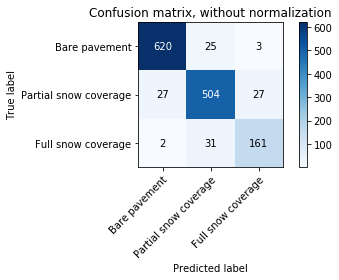

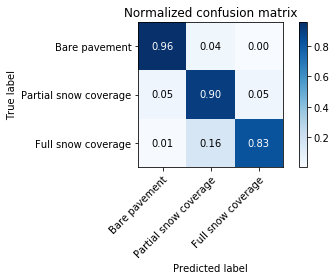

In [51]:
# Evaluate model
np.set_printoptions(precision=2)
print("------------------------------------------------------------")
# Accuracy in the test set
print("Accuracy in the test set: " + "%0.3f" % (accuracy_score(y_test, y_pred_test)))
print("------------------------------------------------------------")
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1), classes=label_names,
#plot_confusion_matrix(y_test.argmax(axis=1), y_pred_test, classes=label_names,
                      title='Confusion matrix, without normalization')
print("------------------------------------------------------------")
# Plot normalized confusion matrix
plot_confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1), classes=label_names, normalize=True,
#plot_confusion_matrix(y_test.argmax(axis=1), y_pred_test, classes=label_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [52]:
# Print more classification scores
sc_precision, sc_recall, sc_f1score, support = precision_recall_fscore_support(y_test.argmax(axis=1), y_pred_test.argmax(axis=1), average='weighted')
print("Precision: "+str(sc_precision))
print("Recall: "+str(sc_recall))
print("F1 score: "+str(sc_f1score))

Precision: 0.917695342814963
Recall: 0.9178571428571428
F1 score: 0.9177677923016538


## Train and evaluate a SVM classifier

In [53]:
from sklearn.svm import SVC

# Tune main hyperparameters by grid search and cross-validation
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-1, 1e-2, 1e-3],
                     'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

# Accuracy is the score of choice
score = 'accuracy'

print("# Tuning hyper-parameters for %s" % score)
svm_clf = GridSearchCV(SVC(), param_grid, cv=5,
                      scoring= score)
svm_clf.fit(X_train_df, y_train.argmax(axis=1))

print("Best parameters set found using cross-validation:")
print()
print(svm_clf.best_params_)
print()
print("Grid scores on cross-validation:")
print()
means = svm_clf.cv_results_['mean_test_score']
stds = svm_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svm_clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters for accuracy
Best parameters set found using cross-validation:

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on cross-validation:

0.958 (+/-0.028) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.957 (+/-0.029) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.956 (+/-0.030) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.957 (+/-0.028) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.957 (+/-0.027) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.957 (+/-0.030) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.027) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.956 (+/-0.027) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.957 (+/-0.029) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.957 (+/-0.030) for {'C': 1, 'kernel': 'linear'}
0.957 (+/-0.030) for {'C': 10, 'kernel': 'linear'}
0.957 (+/-0.030) for {'C': 100, 'kernel': 'linear'}



In [54]:
# Predict for the test set using the best possible combination of parameters 
# from the parameter grid in the previous step
y_pred_test = svm_clf.predict(X_test_df)

------------------------------------------------------------
Accuracy in the test set: 0.918
------------------------------------------------------------
Confusion matrix, without normalization
[[619  27   2]
 [ 24 503  31]
 [  2  29 163]]
------------------------------------------------------------
Normalized confusion matrix
[[0.96 0.04 0.  ]
 [0.04 0.9  0.06]
 [0.01 0.15 0.84]]


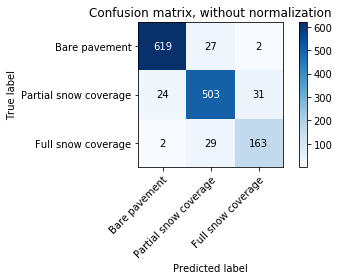

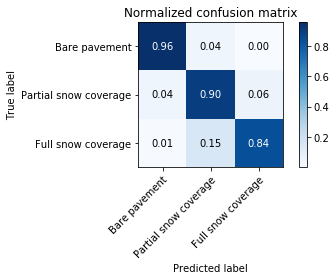

In [55]:
# Evaluate model
np.set_printoptions(precision=2)
print("------------------------------------------------------------")
# Accuracy in the test set
print("Accuracy in the test set: " + "%0.3f" % (accuracy_score(y_test.argmax(axis=1), y_pred_test)))
print("------------------------------------------------------------")
# Plot non-normalized confusion matrix
#plot_confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1), classes=label_names,
plot_confusion_matrix(y_test.argmax(axis=1), y_pred_test, classes=label_names,
                      title='Confusion matrix, without normalization')
print("------------------------------------------------------------")
# Plot normalized confusion matrix
#plot_confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1), classes=label_names, normalize=True,
plot_confusion_matrix(y_test.argmax(axis=1), y_pred_test, classes=label_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [56]:
# Print more classification scores
sc_precision, sc_recall, sc_f1score, support = precision_recall_fscore_support(y_test.argmax(axis=1), y_pred_test, average='weighted')
print("Precision: "+str(sc_precision))
print("Recall: "+str(sc_recall))
print("F1 score: "+str(sc_f1score))

Precision: 0.9180828452515685
Recall: 0.9178571428571428
F1 score: 0.9179642743717087


## Train and evaluate a Naive Bayes classifier

In [57]:
from sklearn.naive_bayes import GaussianNB

# Tune main hyperparameters by grid search and cross-validation
param_grid = [{'var_smoothing': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]}]

# Accuracy is the score of choice
score = 'accuracy'

print("# Tuning hyper-parameters for %s" % score)
nb_clf = GridSearchCV(GaussianNB(), param_grid, cv=5,
                      scoring= score)
nb_clf.fit(X_train_df, y_train.argmax(axis=1))

print("Best parameters set found using cross-validation:")
print()
print(nb_clf.best_params_)
print()
print("Grid scores on cross-validation:")
print()
means = nb_clf.cv_results_['mean_test_score']
stds = nb_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, nb_clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters for accuracy
Best parameters set found using cross-validation:

{'var_smoothing': 0.01}

Grid scores on cross-validation:

0.955 (+/-0.029) for {'var_smoothing': 0.001}
0.955 (+/-0.028) for {'var_smoothing': 0.01}
0.955 (+/-0.027) for {'var_smoothing': 0.1}
0.954 (+/-0.028) for {'var_smoothing': 1}
0.838 (+/-0.018) for {'var_smoothing': 10.0}
0.452 (+/-0.000) for {'var_smoothing': 100.0}
0.452 (+/-0.000) for {'var_smoothing': 1000.0}



In [58]:
# Predict for the test set using the best possible combination of parameters 
# from the parameter grid in the previous step
y_pred_test = nb_clf.predict(X_test_df)

------------------------------------------------------------
Accuracy in the test set: 0.912
------------------------------------------------------------
Confusion matrix, without normalization
[[615  30   3]
 [ 26 498  34]
 [  1  29 164]]
------------------------------------------------------------
Normalized confusion matrix
[[0.95 0.05 0.  ]
 [0.05 0.89 0.06]
 [0.01 0.15 0.85]]


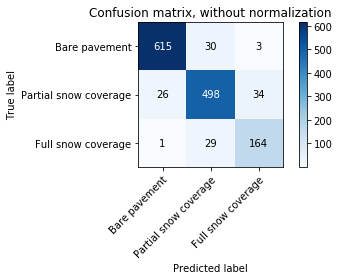

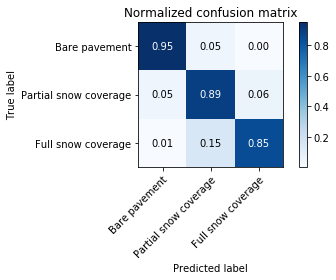

In [59]:
# Evaluate model
np.set_printoptions(precision=2)
print("------------------------------------------------------------")
# Accuracy in the test set
print("Accuracy in the test set: " + "%0.3f" % (accuracy_score(y_test.argmax(axis=1), y_pred_test)))
print("------------------------------------------------------------")
# Plot non-normalized confusion matrix
#plot_confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1), classes=label_names,
plot_confusion_matrix(y_test.argmax(axis=1), y_pred_test, classes=label_names,
                      title='Confusion matrix, without normalization')
print("------------------------------------------------------------")
# Plot normalized confusion matrix
#plot_confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1), classes=label_names, normalize=True,
plot_confusion_matrix(y_test.argmax(axis=1), y_pred_test, classes=label_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [60]:
# Print more classification scores
sc_precision, sc_recall, sc_f1score, support = precision_recall_fscore_support(y_test.argmax(axis=1), y_pred_test, average='weighted')
print("Precision: "+str(sc_precision))
print("Recall: "+str(sc_recall))
print("F1 score: "+str(sc_f1score))

Precision: 0.91280735440663
Recall: 0.9121428571428571
F1 score: 0.9124291234097539
